In [1]:
#r "nuget:Microsoft.DotNet.Interactive.AI, *-*"

Installed Packages Microsoft.DotNet.Interactive.AI, 1.0.0-beta.23468.5

Loading extension script from `C:\Users\dicolomb\.nuget\packages\duckdb.interactiveextension\1.0.108\interactive-extensions\dotnet\extension.dib`

Query DuckDB databases. 
 This extension adds support for connecting to DuckDB databases using the #!connect duckdb magic command. ADO.NET support via DuckDB.NET project

Loading extensions from `C:\Users\dicolomb\.nuget\packages\skiasharp\2.88.5\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

Loading extension script from `C:\Users\dicolomb\.nuget\packages\microsoft.dotnet.interactive.ai\1.0.0-beta.23468.5\interactive-extensions\dotnet\extension.dib`

Added magic commands
 - `#!connect azure-openai`
 - `#!connect openai`
 - `#!connect huggingface`

In [2]:
#!value --name key
YOUR AZURE OPEN AI KEY

In [3]:
#!value --name endpoint
https://your-enpoint.openai.azure.com/

# Use extension to connect to models

In [4]:
#!connect azure-openai --model-type TextEmbeddingGenerator --kernel-name knowledge --api-key @value:key --endpoint @value:endpoint --deployment text-embedding-ada-002

Kernel added: #!knowledge(duckDbVectorRAW)

Kernel added: #!knowledge(duckDbVector)

Kernel added: #!knowledge

In [5]:
#!connect azure-openai --model-type TextCompletion --kernel-name textCompletion --api-key @value:key --endpoint @value:endpoint --deployment text-davinci-003 --use-knowledge knowledge

Kernel added: #!textCompletion(skill)

Kernel added: #!textCompletion

In [6]:
#!connect azure-openai --model-type ImageGenerator --kernel-name image --api-key @value:key --endpoint @value:endpoint --deployment DALL-E

Kernel added: #!image

In [7]:
#!connect azure-openai --model-type ChatCompletion --kernel-name chat --api-key @value:key --endpoint @value:endpoint --deployment gtp-35-turbo --use-knowledge knowledge

Kernel added: #!chat(skill)

Kernel added: #!chat(text)

Kernel added: #!chat

# 1. Hello...

### ... DALL-E


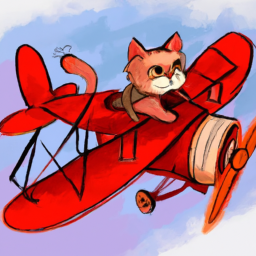

In [8]:
A cat flying a red biplane, in the style of Hiyao Miyazaki.

#### *Points of interest* 

Extensions are able to provide custom visualizations. 

[Our code](https://github.com/jonsequitur/interactive/blob/semantic-kernel-kernel/src/Microsoft.DotNet.Interactive.OpenAI/SkiaUtils.cs)

[SkiaSharp's code](https://github.com/mono/SkiaSharp/blob/main/source/SkiaSharp.DotNet.Interactive/SkiaSharpKernelExtension.cs)

# 2. Skills

### Defining semantic functions for `Microsoft.SemanticKernel`

In [9]:
#!function -h

Description:
  Indicates that the cell contents should be used to define a semantic function.

Usage:
  #!function <functionName> [options]

Arguments:
  <functionName>  The name of the function to be defined.

Options:
  --skill <skill>              The name of the skill to which the function should be added.
  --description <description>  The description of the function.
  --max-tokens <max-tokens>    The maximum number of tokens to generate in the completion. The token count of your prompt plus max_tokens can't exceed the model's context length. Most models have a context length of 2048 tokens (except davinci-codex, which supports 4096).
  -?, -h, --help               Show help and usage information





In [10]:
#!function summarize --skill writer
Summarize the following text. 
[BEGIN TEXT]
{{$input}}
[END TEXT]

In [11]:
#!function stylist --skill writer
Rewrite the following text in the style of {{$person}}:
[BEGIN TEXT]
{{$input}}
[END TEXT]
Please write it in verse.

In [12]:
#!set --name person --value @input:"Whose style would you like to summarize this in?"
#!use-skills function.writer.summarize function.writer.stylist
.NET Interactive engine can be used many ways.
* It takes messages, routes them to subkernels, and can format returned data.
* Messages are initiated via a host (like Polyglot Notebooks).
* Subkernels can be a bunch of different languages (including Mermaid).
* Subkernels can share data.
* Subkernels can be running in different processes and on different machines.
* We'd love your ideas on how we can leverage this for developers.


Powerful tool, the .NET Interactive engine,
Routing messages, formatting data, sharing between languages and processes seen.
Initiated via a host, Polyglot Notebooks,
A variety of ways to use it, we seek.
Ideas on how to best leverage this engine for developers,
We are looking for, yes.

# 3. Kernels

### Using multiple AI models together

In [13]:
#!function make_image_prompt --skill image
{{$input}}
Describe an image of the text above in {{$linecount}} lines.

In [14]:
#!function safe --skill image
{{$input}}
Rewrite the text above to be ok to read with a 6 years old child.

In [15]:
#!function improve --skill image
{{$input}}
Turn the text above into a better and more detailed prompt for DALL-E.

In [17]:
#!set --name linecount --value 10
#!use-skills function.image.make_image_prompt function.image.safe function.image.improve 

A cat flying a red biplane, in the style of Hiyao Miyazaki.

DALL-E, create an image of a small white cat flying a bright red biplane through a beautiful orange sky at sunset. The cat should have its tail held high in the air, its whiskers twitching, and its paws gripping the controls. In the background, a flock of birds should be flying in formation. The plane should be glimmering in the light of the setting sun, and the cat should have a look of excitement and delight on its face.

In [16]:
using Microsoft.DotNet.Interactive;
using Microsoft.DotNet.Interactive.Commands;
using Microsoft.DotNet.Interactive.Events;

var prompts = new List<string>();

Kernel.Root.KernelEvents.Subscribe(e =>
{
    if (e is ReturnValueProduced rvp &&
        e.Command.TargetKernelName.Contains("textCompletion") &&
        rvp.FormattedValues.SingleOrDefault(v => v.MimeType == "text/plain") is { } plainTextValue)
    {
        prompts.Add(plainTextValue.Value);
    }
});

Sending this prompt to DALL-E: *DALL-E, create an image of a small white cat flying a bright red biplane through a beautiful orange sky at sunset. The cat should have its tail held high in the air, its whiskers twitching, and its paws gripping the controls. In the background, a flock of birds should be flying in formation. The plane should be glimmering in the light of the setting sun, and the cat should have a look of excitement and delight on its face.*


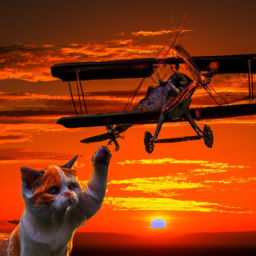

In [19]:
using Microsoft.DotNet.Interactive;
using Microsoft.DotNet.Interactive.AI;

var dallEKernel = Kernel.Root.FindKernels(k => k is ImageGenerationKernel).Single(k => k.Name == "image");

var lastPrompt = prompts.Last().Trim();
$"Sending this prompt to DALL-E: *{lastPrompt}*".DisplayAs("text/markdown");

var result = await dallEKernel.SendAsync(new SubmitCode(lastPrompt));

# 4. Bonus round

In [20]:
Can we talk about code?

Yes, as an AI language model, I can talk about code. What would you like to discuss?

## `#!explain` redux

In [21]:
using Microsoft.DotNet.Interactive;
using Microsoft.DotNet.Interactive.Events;
using Microsoft.DotNet.Interactive.Commands;
using Microsoft.DotNet.Interactive.AI;
using System.CommandLine;

var explainMagicCommand = new Command("#!explain");

explainMagicCommand.SetHandler(async _ =>
{
    var context = KernelInvocationContext.Current;
    if (context.Command is SubmitCode submitCode)
    {
        var prompt = $"""
            {submitCode.Code.Replace("#!explain", "")}
            Explain what the code above does, using dad jokes.
            """;
        
        await Kernel.Root.FindKernels(k => k is ChatCompletionKernel).Single(k => k.Name == "chat")
                    .SendAsync(new SubmitCode(prompt));

        context.Complete(submitCode);
    }
});

Kernel.Root.AddDirective(explainMagicCommand);

In [22]:
#!explain
foreach (var i in Enumerable.Range(1, 10))
{
    if (i % 2 == 0)
    {
        Console.WriteLine(i);
    }
}

Sure, I'll give it a try!

Why did the programmer go to the beach? To write some "foreach" loops! 

So, this code is using a "foreach" loop to iterate over a range of numbers from 1 to 10. But it's not just any range of numbers - it's an "Enumerable" range! 

Now, the loop is checking each number to see if it's divisible by 2 (using the modulo operator). If it is, then it's an even number! And what do we do with even numbers? We "Console.WriteLine" them, of course! 

So, in summary: this code is finding all the even numbers between 1 and 10 and printing them out to the console. It's a simple but effective way to practice using "foreach" loops and conditionals.

In [23]:
using Microsoft.DotNet.Interactive;
using Microsoft.DotNet.Interactive.Events;
using Microsoft.DotNet.Interactive.Commands;
using Microsoft.DotNet.Interactive.AI;
using System.CommandLine;

var rewriteMagicCommand = new Command("#!rewrite");

rewriteMagicCommand.SetHandler(async _ =>
{
    var context = KernelInvocationContext.Current;
    if (context.Command is SubmitCode submitCode)
    {
        var prompt = $"""
            {submitCode.Code.Replace("#!rewrite", "")}
            Rewrite the code above in python. just output the code, no markdown.
            """;
        
        await Kernel.Root.FindKernels(k => k is ChatCompletionKernel).Single(k => k.Name == "chat")
                    .SendAsync(new SubmitCode(prompt));

        context.Complete(submitCode);
    }
});

Kernel.Root.AddDirective(rewriteMagicCommand);

In [24]:
#!rewrite
foreach (var i in Enumerable.Range(1, 10))
{
    if (i % 2 == 0)
    {
        Console.WriteLine(i);
    }
}

```python
for i in range(1, 11):
    if i % 2 == 0:
        print(i)
```

In [25]:
using Microsoft.DotNet.Interactive;
using Microsoft.DotNet.Interactive.Events;
using Microsoft.DotNet.Interactive.Commands;
using Microsoft.DotNet.Interactive.AI;
using System.CommandLine;

var unwindMagicCommand = new Command("#!unwind");

unwindMagicCommand.SetHandler(async _ =>
{
    var context = KernelInvocationContext.Current;
    if (context.Command is SubmitCode submitCode)
    {
        var prompt = $"""
            {submitCode.Code.Replace("#!unwind", "")}
            Rewrite the code above without recursion. Use iterations instead of recursion. just output the code, no markdown.
            """;
        
        await Kernel.Root.FindKernels(k => k is ChatCompletionKernel).Single(k => k.Name == "chat")
                    .SendAsync(new SubmitCode(prompt));

        context.Complete(submitCode);
    }            
});

Kernel.Root.AddDirective(unwindMagicCommand);

In [26]:
#!unwind
int fibonacci(int x){
    switch (x){
        case 0: 
        return 1;
        case 1: 
        return 1;
        default:
        return fibonacci(x-1) + fibonacci(x-2);

    }
}

```csharp
int fibonacci(int x){
    int a = 1, b = 1, c = 0;
    if (x == 0 || x == 1) {
        return 1;
    }
    for (int i = 2; i <= x; i++) {
        c = a + b;
        a = b;
        b = c;
    }
    return c;
}
```

## Comparing models

In [28]:
Here are some resturants I would like to eat at in Mexico City between April 27 and May 3. 

* Maximo Bistro Tencui
* Mi Compa Chava Mariscos Contramar
* Paramo
* Masala y Maiz
* Limosneros
* Nicos
* El Hidalguense

Which ones will I not need reservations for?

You will not need reservations for Maximo Bistro Tencui, Masala y Maiz, Limosneros, and El Hidalguense.

In [29]:
Here are some resturants I would like to eat at in Mexico City between April 27 and May 3. 

* Maximo Bistro Tencui
* Mi Compa Chava Mariscos Contramar
* Paramo
* Masala y Maiz
* Limosneros
* Nicos
* El Hidalguense

Which ones will I not need reservations for?

It's difficult to say for certain whether you will need reservations for any of these restaurants during your desired dates, as it depends on factors such as the popularity of the restaurant, the time of day you plan to visit, and whether there are any special events or holidays happening during your stay. However, in general, it's always a good idea to make reservations in advance to ensure that you can secure a table at your desired restaurant. 

That being said, some of the restaurants on your list may be less busy than others and may be more likely to have availability without a reservation. For example, El Hidalguense is a casual restaurant that specializes in traditional Hidalgo-style cuisine, and it may be easier to get a table there without a reservation. However, for the other restaurants on your list, it's recommended to make a reservation in advance to avoid disappointment.

## Misc.

In [ ]:
#!set --name person --value @input:"Enter the name of the person you'd like to summarize this text."
#!use-skills function.writer.stylist

What is .NET Interactive?

It takes messages, routes them to subkernels, and can format returned data
Messages are initiated via a host
Subkernels can be a bunch of different languages (including Mermaid)
Subkernels can share data
Subkernels can be running in different processes or on different machines
We’d love your ideas on how we can leverage this for developers



In [30]:
#!function explainer --skill writer
{{$input}} 

Summarize the text above in the style of Randall Munroe's Thing Explainer, using only words that are amongst the most common 500 english words


In [31]:
#!function detect_intent 
Intent detection examples start here:
Intent: Unknown:
    * save
    * send
Intent: Help:
    * How can you help me?
    * What can you do?
Intent: TellAJoke:
    * What's the best joke you know?
    * Do you know any joke?
    * Tell me a joke
    * Tell me something funny
Intent: WhatTimeIsIt
    * tell me the time please
    * time and date please
    * what time is it?
    * what's the current time?
    * is it lunch time yet?
    * is it dinner time?
== end of examples ==
Input: {{$input}}
Intent:

In [34]:
#!use-skills function._GLOBAL_FUNCTIONS_.detect_intent

I could really use some help understanding intent detection.

Help

In [35]:
#!use-skills function.writer.explainer

Since .NET Interactive is capable of running as a kernel for notebooks, it enables a polyglot (multi-language) notebook experience. When using the .NET Interactive kernel, you can use different languages from one cell to the next, share variables between languages, and dynamically connect new languages and remote kernels within a notebook. There's no need to install different Jupyter kernels, use wrapper libraries, or install different tools to get the best experience for the language of your choice. You can always use the best language for the job and seamlessly transition between different stages of your workflow, all within one notebook.

For the best experience when working with multi-language notebooks, we recommend installing the Polyglot Notebooks extension for Visual Studio Code. While the full .NET Interactive feature set is available in Jupyter, many features are only usable via code, whereas the Polyglot Notebooks extension provides additional features including a language/kernel picker for each cell, enhanced language services, a multi-kernel variable viewer, and more.

.NET Interactive is a tool that lets you use different languages in one notebook. You don't need to install different tools, just use the best language for the job. To get the best experience, install the Polyglot Notebooks extension for Visual Studio Code. It has a picker for each cell, better language services, and a viewer for different kernels.